In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance


## Data Preprocessing and Cleaning (same for both models NN and Ridge Regression)

In [2]:
# Load the dataset
data = pd.read_csv("day.csv")

# Drop unnecessary features
data = data.drop(columns=["atemp", "instant", "mnth", "dteday", "holiday", "weekday", "windspeed", "registered", "casual"])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=["season", "weathersit"], drop_first=True)

# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter rows that are within the bounds
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each numeric feature
numeric_features = ["temp", "hum", "cnt"]
for feature in numeric_features:
    data = remove_outliers(data, feature)

X = data.drop(columns=["cnt"]) # features
y = data['cnt']  # target

# Scale and normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Build Model

In [3]:
# Initialize Ridge Regression model
ridge = Ridge()

# Define the hyperparameter grid for alpha (regularization strength)
# Alpha values range from 0.001 to 1000 in a logarithmic scale (10 values)
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
# Scoring is based on negative mean squared error (MSE)
ridge_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=KFold(5))

# Train Ridge Regression model with cross-validation to find the best alpha
ridge_cv.fit(X_train, y_train)

# Get the best Ridge Regression model (with optimal alpha)
best_ridge = ridge_cv.best_estimator_

## RSME, R², MAE

In [4]:
# Make predictions on the test set using the best Ridge model
ridge_y_pred = best_ridge.predict(X_test)

# Evaluate the performance of the Ridge model using metrics
ridge_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, ridge_y_pred)),  # Root Mean Squared Error
    'R²': r2_score(y_test, ridge_y_pred),                     # Coefficient of Determination
    'MAE': mean_absolute_error(y_test, ridge_y_pred),          # Mean Absolute Error
}

# Get the best alpha value found during GridSearchCV
best_alpha = ridge_cv.best_params_['alpha']

# Print the results
print(f"Best Ridge Alpha: {best_alpha:.3f}")  # Optimal alpha value
print(f"Ridge Regression Metrics:")          # Model performance metrics
print(f"  - R² Score: {ridge_metrics['R²']:.3f}")       # R-squared score
print(f"  - Mean Squared Error (MSE): {ridge_metrics['RMSE']:.2f}")  # RMSE
print(f"  - Mean Absolute Error (MAE): {ridge_metrics['MAE']:.2f}")  # MAE

Best Ridge Alpha: 10.000
Ridge Regression Metrics:
  - R² Score: 0.824
  - Mean Squared Error (MSE): 784.07
  - Mean Absolute Error (MAE): 593.00


## Performance Plots

### 1. Predicted vs. Actual

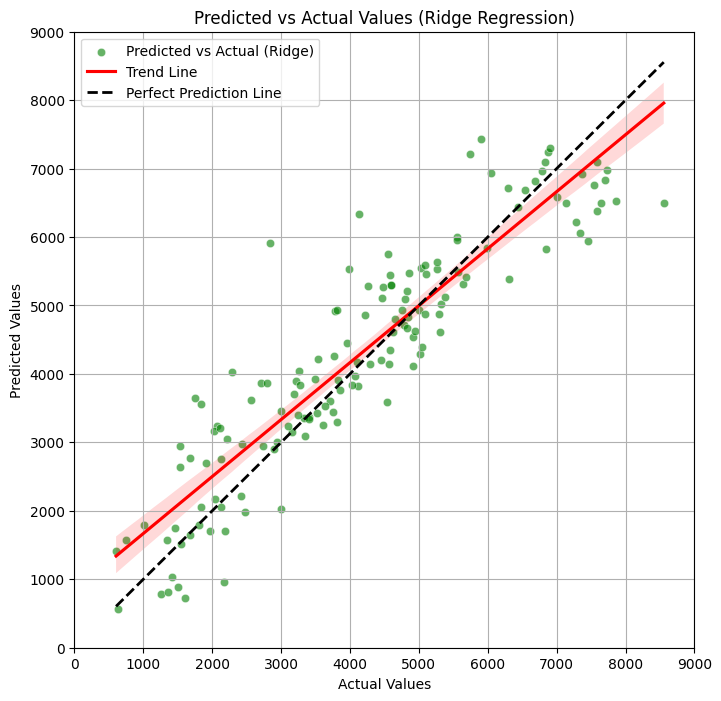

In [5]:
plt.figure(figsize=(8, 8))

# scatter plot
sns.scatterplot(x=y_test, y=ridge_y_pred, alpha=0.6, color="green", label="Predicted vs Actual (Ridge)")

# regression trend line
sns.regplot(x=y_test, y=ridge_y_pred, scatter=False, color="red", label="Trend Line")

# perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="Perfect Prediction Line")

# making plot readable
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (Ridge Regression)")
plt.legend()
plt.grid(True)

# consistent scale
plt.xlim([0, 9000])
plt.ylim([0, 9000])

plt.show()

### 2. Normalized Feature Importance

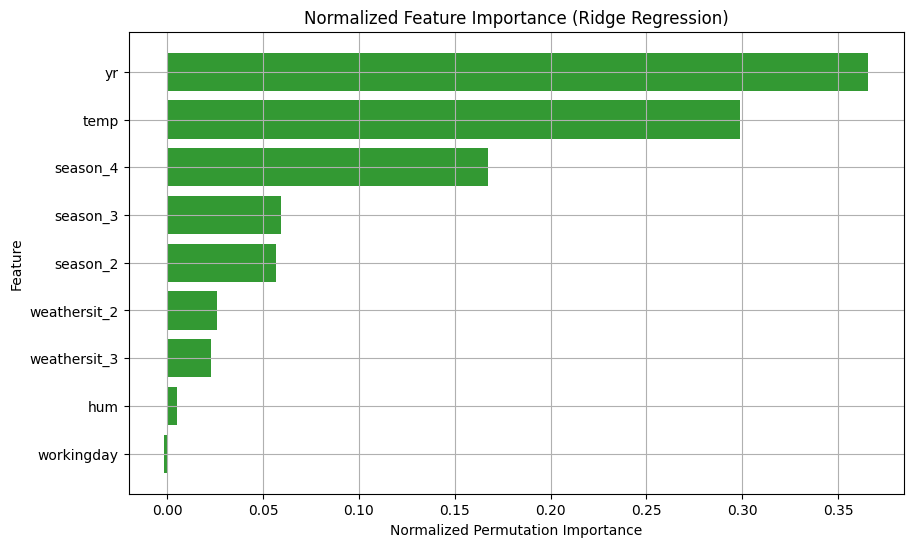

In [6]:
# Compute permutation importance
perm_importance = permutation_importance(best_ridge, X_test, y_test, n_repeats=10, random_state=42)

# Normalize the importance scores
importances_mean = perm_importance.importances_mean
normalized_importance = importances_mean / importances_mean.sum()  # Normalize to sum to 1

# Extract feature names and sort them
sorted_idx = normalized_importance.argsort()

# Plot Normalized Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], normalized_importance[sorted_idx], color="green", alpha=0.8)
plt.xlabel("Normalized Permutation Importance")
plt.ylabel("Feature")
plt.title("Normalized Feature Importance (Ridge Regression)")
plt.grid(True)
plt.show()

### 3. Residual Plot

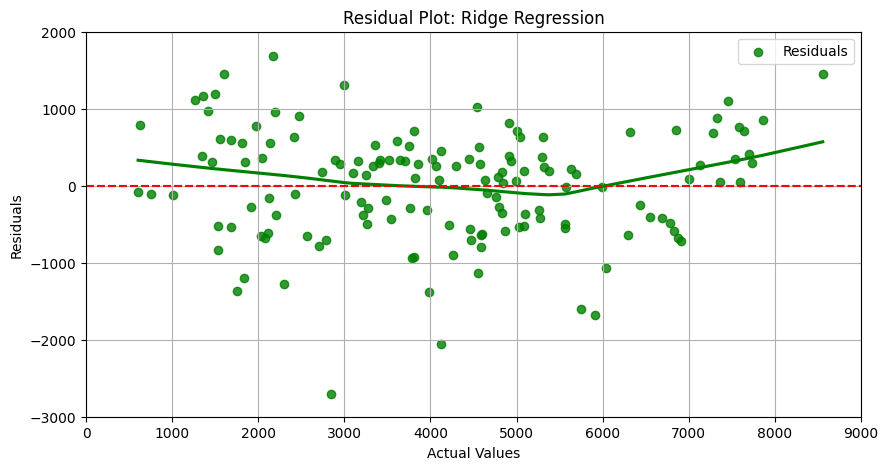

In [7]:
# Calculate residuals
residuals = y_test - ridge_y_pred

plt.figure(figsize=(10, 5))

# Residual plot: Visualize residuals as a function of actual values
# 'lowess=True' adds a locally weighted regression line to show the trend in residuals
sns.residplot(x=y_test, y=residuals, lowess=True, color="green", label="Residuals")

# Add a horizontal line at 0 to represent no residual (perfect prediction)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)

# making plot readable
plt.title("Residual Plot: Ridge Regression")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)

# consistent scale
plt.xlim([0, 9000])
plt.ylim([-3000, 2000])

plt.show()

### 4. Distribution of Residuals

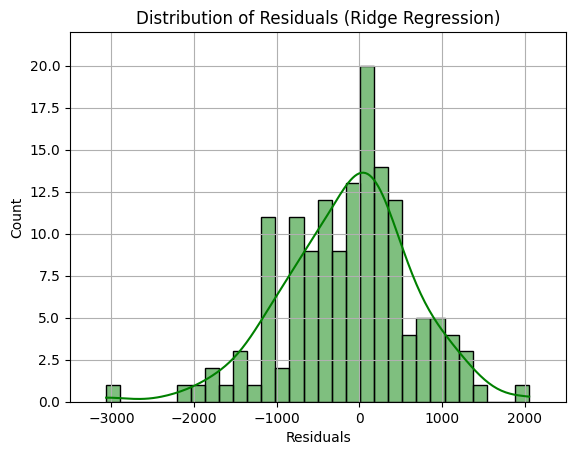

In [8]:
# sns.histplot creates a histogram of residual values with a KDE (Kernel Density Estimate) overlay
sns.histplot(residuals, kde=True, color="green", bins=30)

# making plot readable
plt.xlabel("Residuals")
plt.title("Distribution of Residuals (Ridge Regression)")
plt.grid(True)

# consistent scale
plt.xlim([-3500, 2500])
plt.ylim([0.0, 22.0])

plt.show()